In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()
sys.path.append(paths.inhouse+'/dif/python')

# from Yesh's DIF_IP script
from pixval import Formatter
import dif_utils
from enum import IntEnum
from skimage import measure

green = (0, 255, 0)

Paths defined in paths module:
 paths.tmp_dir: /Users/trafferty/tmp
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.projects_root: /Users/trafferty/data/projects
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.images_root: /Users/trafferty/data/images
 paths.inhouse: /Users/trafferty/dev/src/inhouse
 paths.ws_dir: /Users/trafferty/workspace
 paths.results_root: /Users/trafferty/data/results
 paths.mii_home: /Users/trafferty/dev
 paths.data_root: /Users/trafferty/data
 paths.tmp_root: /Users/trafferty/data/tmp


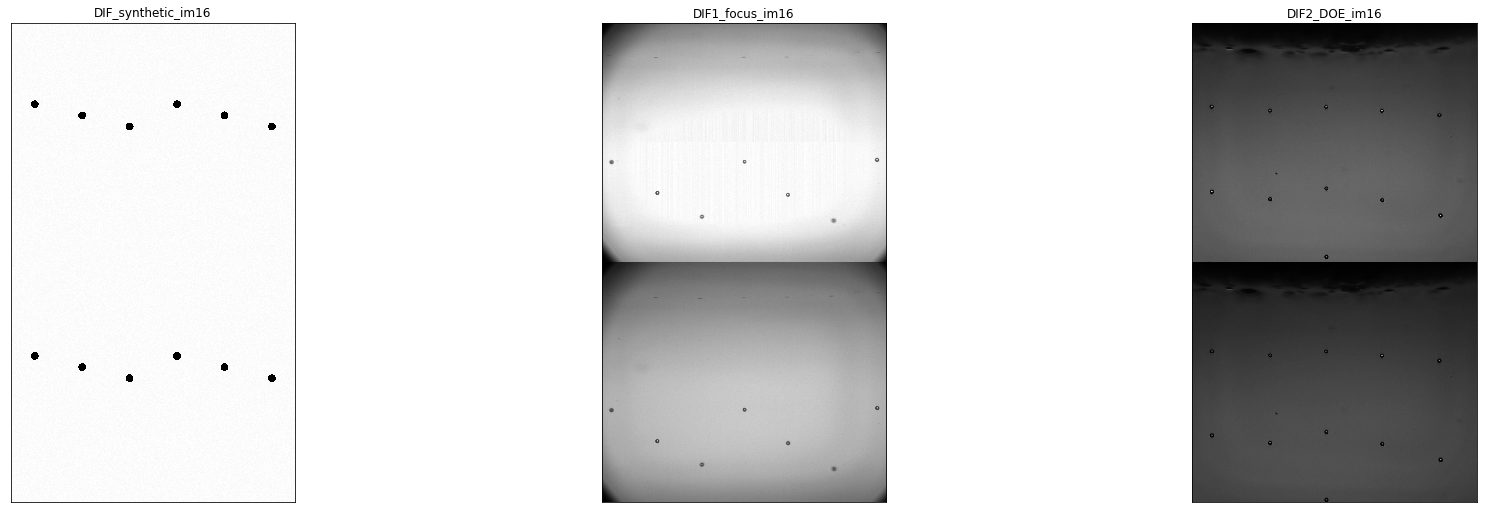

In [2]:
DIF_synthetic_path=paths.tmp_dir+'/DIF/dif_images/DIF_Synthetic_with_proper_metadata.png'
DIF1_focus_path=paths.tmp_dir+'/DIF/dif_images/focus/+0/2017-09-29_09.22.41/DispenserOpt_00006_2017-09-29_09.22.54.png'
DIF2_DOE_path=paths.tmp_dir+'/DIF/DIF2_2018-04-12_12.07.25/DispenserOpt_00001_2018-04-12_12.07.27.png'

DIF_synthetic_im16 = cv2.imread(DIF_synthetic_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
DIF1_focus_im16 = cv2.imread(DIF1_focus_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
DIF2_DOE_im16 = cv2.imread(DIF2_DOE_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

#imgplot =plt.imshow(im16, cmap='gray')
#plt.colorbar()

util.plot_imgs([(DIF_synthetic_im16, 'DIF_synthetic_im16'), (DIF1_focus_im16, 'DIF1_focus_im16'), (DIF2_DOE_im16, 'DIF2_DOE_im16')], max_cols = 3)

In [3]:
DIF_sythetic_metadata = dif_utils.getMetadata(DIF_synthetic_path)
       
'''
As of 05/01/2018, the metadata should have the following fields:

Keys in both:
'''
metadata_05_01_2018_fields = ['PD_start_us', 'PD_delay_us', 'qsw2_start_us', 'drop_pattern_gap_us', 'git-sha', 'double_shutter', 'qsw1_start_us', 'ExperimentID', 
                              'DispenseBitmapFile', 'Location', 'ImageID', 'lamp1_start_us', 'Camera', 'HeadSerialNumber', 'cam1_int_start_us', 'MonomerID', 
                              'Waveform', 'start_time_us', 'lamp2_start_us', 'git-branch', 'Magnification', 'cam3_int_start_us', 'double_shutter_delay_us', 
                              'drop_latency_us', 'Nozzle', 'DIF_Version', 'cam2_int_start_us', 'NozzleID', 'cycle_time_us', 'Phase', 'Row', 'Loop_Count', 
                              'Total_Loops', 'ExperimentType', 'SecondaryNozzles', 'PrimaryNozzles', 'HeadName', 'Mean_Time_per_Loop', 'Est_Completion_Time', 
                              'ExperimentIndex', 'Run_Mode', 'Sample_Clock', 'Global_Voltage', 'Elapsed_Time', 'elapsed_ms', 'ImageFile', 'ExpFolder']

'''
...broken down into the following categories:
'''    

exp_fields = [ 
 'git-sha', 'git-branch','double_shutter', 'ExperimentID','Location', 'Camera', 'HeadSerialNumber', 
 'MonomerID', 'Magnification', 'SecondaryNozzles', 'PrimaryNozzles', 'HeadName', 'ExpFolder', 'DIF_Version']

loop_fields = ['PD_delay_us',  'DispenseBitmapFile',  'ImageID',  'Waveform', 'double_shutter_delay_us',  
 'Nozzle', 'NozzleID', 'Phase', 'Row', 'Loop_Count', 'Total_Loops', 'ExperimentType', 'ExperimentIndex']

DIF_Server_fields = [ 'ImageFile', 'Mean_Time_per_Loop', 'Est_Completion_Time', 'Run_Mode', 'Elapsed_Time', 'elapsed_ms']

xaar_fields = ['Sample_Clock', 'Global_Voltage']
 
timing_fields = ['PD_start_us', 'qsw2_start_us', 'drop_pattern_gap_us', 'qsw1_start_us', 'lamp1_start_us', 'drop_latency_us',
 'cam1_int_start_us', 'start_time_us', 'lamp2_start_us', 'cam3_int_start_us', 'cam2_int_start_us', 'cycle_time_us',]

all_fields = exp_fields + loop_fields + DIF_Server_fields + xaar_fields + timing_fields 

required_fields = exp_fields + loop_fields

#print(all_fields)

# first let's make sure all_fields is made up of all of metadata_05_01_2018_fields:
for k in metadata_05_01_2018_fields:
    if k not in all_fields:
        print("all_fields missing: ", k)

# Ok, now see if synth img has any fields that are not in all_fields
for k in DIF_sythetic_metadata.keys():
    if k not in all_fields:
        print("synth has field not in all_fields: ", k)
        
# And, most important, are there any missing required fields
for k in required_fields:
    if k not in DIF_sythetic_metadata:
        print("synth missing required field: ", k)


In [8]:
DIF1_focus_metadata_dict = dif_utils.getMetadata(DIF1_focus_path)
DIF2_metadata_dict = dif_utils.getMetadata(DIF2_DOE_path)

# For our test processing images (focus and DIF2), see what fields they are missing
for k in required_fields:
    if k not in DIF1_focus_metadata_dict:
        print("focus missing required field: %s setting to %s"% (k, DIF_sythetic_metadata[k]) )
        DIF1_focus_metadata_dict[k] = DIF_sythetic_metadata[k]
for k in required_fields:
    if k not in DIF2_metadata_dict:
        print("DIF2 missing required field: %s setting to %s"% (k, DIF_sythetic_metadata[k]) )
        DIF2_metadata_dict[k] = DIF_sythetic_metadata[k]

# then tweak them if necessary:
DIF1_focus_metadata_dict["PrimaryNozzles"] = "3,0,6"
DIF1_focus_metadata_dict["SecondaryNozzles"] = "1,2,4,5"

DIF2_metadata_dict["PrimaryNozzles"] = "2,0,1,3,4"
DIF2_metadata_dict["SecondaryNozzles"] = ""
DIF2_metadata_dict["HeadName"] = "OceF1Chip"
DIF2_metadata_dict["Location"] = "DIF2 Station"

print(DIF1_focus_metadata_dict)

focus missing required field: SecondaryNozzles setting to 1,2,4,5
focus missing required field: PrimaryNozzles setting to 3,0
focus missing required field: HeadName setting to Xaar100x
focus missing required field: ExpFolder setting to /media/DIF_DATA/images/Rel_Test_2018-05-01_16.30.25
focus missing required field: ExperimentType setting to DispenseOpt
focus missing required field: ExperimentIndex setting to 0
DIF2 missing required field: git-sha setting to ce5787839b30ec51a7671e4c465a284793ceb1c1
DIF2 missing required field: git-branch setting to dif_branch
DIF2 missing required field: Location setting to DIF Station
DIF2 missing required field: Camera setting to Andor
DIF2 missing required field: Magnification setting to 20x
DIF2 missing required field: SecondaryNozzles setting to 1,2,4,5
DIF2 missing required field: HeadName setting to Xaar100x
DIF2 missing required field: ExpFolder setting to /media/DIF_DATA/images/Rel_Test_2018-05-01_16.30.25
DIF2 missing required field: DIF_Vers

In [19]:
DIF1_ip_config = {
           "rMin": 750,
           "rMax": 2160,
           "timeLapse_us": 4,
           "pxSize_um": 0.345,
           "frameHeight_px": 2160,
           "frameWidth_px": 2560,
           "bg_thresh": 30,
           "circTh": 0.7,
           "maxDropsPerImg": 200,
           "nozzSpacing_um": 141.1082,
           "phaseIDs": [1,2,3]
       }

DIF2_ip_config = {
           "rMin": 750,
           "rMax": 2160,
           "timeLapse_us": 4,
           "pxSize_um": 0.309,
           "frameHeight_px": 2160,
           "frameWidth_px": 2560,
           "bg_thresh": 30,
           "circTh": 0.7,
           "maxDropsPerImg": 200,
           "nozzSpacing_um": 169.333,
           "phaseIDs": [1]
       }

In [18]:
img_path = DIF1_focus_path
metadata_dict = DIF1_focus_metadata_dict
ip_config = DIF1_ip_config

In [35]:
from collections import namedtuple
ROI = namedtuple('ROI', ['startY', 'endY', 'startX', 'endX'])
    
def getROI(img, roi):
    return (img[roi.startY:roi.endY, roi.startX:roi.endX])

def findBLOBs(img):
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 150;

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = .8

    # # Filter by Convexity
    params.filterByConvexity = False
    # params.minConvexity = 0.87

    # # Filter by Inertia
    params.filterByInertia = False
    # params.minInertiaRatio = 0.9

    params.filterByColor = False
    params.filterByArea = True
#     params.minArea = 4 * np.pi
#     params.maxArea = 100 * np.pi
    params.minArea = 20
    params.maxArea = 500

    detector = cv2.SimpleBlobDetector_create(params)
    #detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(img)
    return keypoints

def findROI(img8, tag="", debug=True):
    plot_list = []
    plot_list.append( (img8,'roi:%s'%tag) )
    
    keypoints = findBLOBs(img8)
    if debug: print( "[findROI] num keypoints found: ", len(keypoints))

    if len(keypoints):
        # Draw detected blobs as red circles.
        # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
        #roi_with_keypoints = cv2.drawKeypoints(roi, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        kp = keypoints[0]
        x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
        if debug: print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))

        roi = img8.copy()[y-75:y+75, 1:col_width]

        if debug:
#             plot_list.append( (roi,'roi:%s'%tag) )
            cv2.circle(img8, (x, y), int(dia/2), (0,0,255),2)
            cv2.line(img8, (x, y-dia), (x, y+dia), (0,0,255), 3)
            cv2.line(img8, (x-dia, y), (x+dia, y), (0,0,255), 3)
            #plot_list.append( (col_img,'Keypoints') )
        #cv2.rectangle(img8, (sx, sy), (sx+w, sy+h), (0,0,0), 10) # two corners: (startX, startY), (endX, endY)                

    if debug:
        util.plot_imgs(plot_list)
    
    if len(keypoints):
        return True, roi
    else:
        return False, None

num_cols:  7
coi:  3
col_width:  365


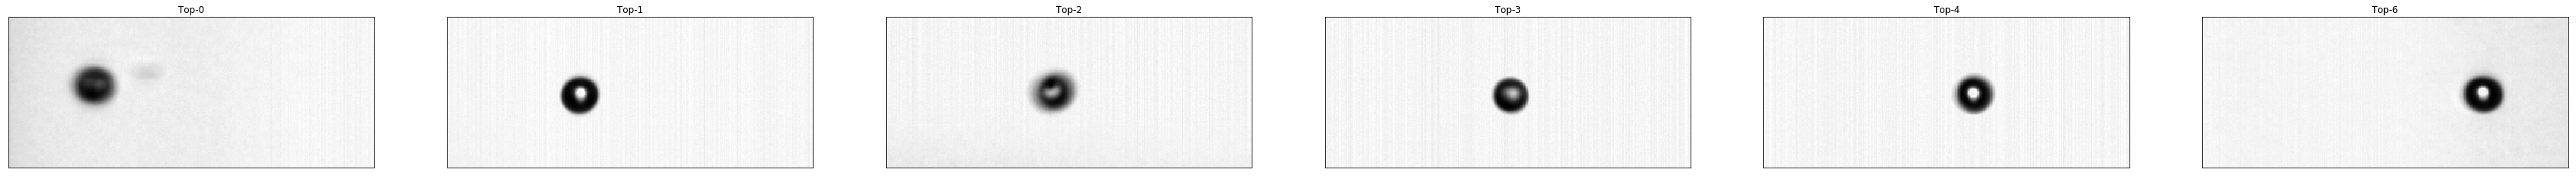

In [36]:
plot_list = []

im16 = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

rows, cols = im16.shape
midX, midY = int(cols/2), int(rows/2)

top_col_roi_lst = []
bot_col_roi_lst = []

rMin = 200

primary_nozzles = [int(x) for x in metadata_dict["PrimaryNozzles"].split(',')]
secondary_nozzles = [int(x) for x in metadata_dict["SecondaryNozzles"].split(',')]

num_cols = len(primary_nozzles)+len(secondary_nozzles)
coi = primary_nozzles[0]
col_width = int(cols/num_cols)

print("num_cols: ", num_cols)
print('coi: ', coi)
print('col_width: ', col_width)

for i in range(num_cols):
    startY = ip_config["rMin"]
    endY   = midY
    startX = i*col_width
    endX   = startX+col_width
    roi = ROI(startY=startY, endY=endY, startX=startX, endX=endX)
    top_col_roi_lst.append(ROI(startY=startY, endY=endY, startX=startX, endX=endX))
    bot_col_roi_lst.append(ROI(startY=midY+startY, endY=midY+endY, startX=startX, endX=endX))

for idx, roi in enumerate(top_col_roi_lst):    
    #plot_list.append((getROI(im16, roi), "Top-%d"%idx))
    found, roi_img = findROI(dif_utils.convert16BitTo8Bit(getROI(im16, roi)), tag="Top-%d"%idx, debug=False)
    if found:
        plot_list.append((roi_img, "Top-%d"%idx))
                     
# for idx, roi in enumerate(bot_col_roi_lst):    
#     plot_list.append((getROI(im16, roi), "Bot-%d"%idx))
                     
util.plot_imgs(plot_list, max_cols = num_cols)

### From DIF_ImageProcessor.readAndCropImages

In [ ]:
#im16 = cv2.imread('../images/DispenserOpt_00097_2016-10-31_14.03.19.png', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# First make 2D by slicing out one channel
if len(im16.shape) == 3:
    im16 = im16[:,:,1]

# if 16bit, convert to 8bit
if im16.dtype.name.find('16') >= 0:
    im8 = bu.convert16BitTo8Bit(im16)
else:
    im8 = im16

# now subimage into ref and tgt
if (im8.shape[0] == 2*frameHeight_px):
    ITgt = im8[frameHeight_px+rMin:frameHeight_px+rMax:rStep,cMin:cMax:cStep]

IRef = im8[rMin:rMax:rStep,cMin:cMax:cStep]
IRef16 = im16[rMin:rMax:rStep,cMin:cMax:cStep]

util.plot_imgs([(IRef, 'IRef'), (ITgt, 'ITgt')], max_cols = 2)

### Preprocess and find blobs in Ref image

In [ ]:
def simplePreProcAndBinarize(img):
    gauBlur1 = cv2.GaussianBlur(img,(3,3),0)
    gauBlur2 = cv2.GaussianBlur(img,(11,11),0)
    diffOfGau = gauBlur1-gauBlur2
    dog_med = cv2.medianBlur(diffOfGau, 5, 0)
    ret, im_thresh = cv2.threshold(dog_med,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    util.plot_imgs([(img, 'img'), (gauBlur1, 'gauBlur1'),(gauBlur2, 'gauBlur2'),(diffOfGau, 'diffOfGau'),(dog_med, 'dog_med'),(im_thresh, 'im_thresh')], max_cols = 2)
    return im_thresh


In [ ]:
# Ref image processing
#---------------------
# Preprocess and binarize reference image
#iRef_th = bu.preprocAndBinarizeImg(iRef, blurKernelSize, tophatKernalSize, minThVal, maxThVal, thresholdType)
#iRef_th = bu.simplePreProcAndBinarize(IRef16)
iRef_th = simplePreProcAndBinarize(IRef)

# Find, label and size up the blobs
labelArrRef = measure.label(iRef_th)

# Measure properties of labeled image regions.
#  http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
RegPropsRef = measure.regionprops(labelArrRef)

numBlobsRef = len(RegPropsRef)
print("There are %d region properties found:" % (numBlobsRef))
      
# for i in range(numBlobsRef):
#     print(RegPropsRef[i].centroid)

blobCentroidsRef = np.array([RegPropsRef[i].centroid for i in range(numBlobsRef)])

util.plot_imgs([(iRef_th, 'iRef_th')], max_cols = 2)

### What did we find? Filter out according to circTh, minSzInPx, maxSzInPx

In [ ]:
# Blob centroids after particle filter
FiltIdxRef, numGoodBlobsRef = bu.pruneBlobs(RegPropsRef, circTh, minSzInPx, maxSzInPx)
print("numGoodBlobsRef: %d" % (numGoodBlobsRef))

In [ ]:
# Good blob indices are 0:numGoodBlobs-1 and bad blob indices numGoodBlobs+1:-1
FiltIdxRef = FiltIdxRef[0:numGoodBlobsRef]

blobCentFiltRef = blobCentroidsRef[FiltIdxRef[0:numGoodBlobsRef]]
RegPropsRefFilt = [RegPropsRef[i] for i in FiltIdxRef[0:numGoodBlobsRef]]

print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsRef), len(RegPropsRefFilt)))


### Now process the Target image...

In [ ]:
iTgt_th = bu.simplePreProcAndBinarize(ITgt)
labelArrTgt = measure.label(iTgt_th)
RegPropsTgt = measure.regionprops(labelArrTgt)
numBlobsTgt = len(RegPropsTgt)
blobCentroidsTgt = np.array([RegPropsTgt[i].centroid for i in range(numBlobsTgt)])
FiltIdxTgt, numGoodBlobsTgt = bu.pruneBlobs(RegPropsTgt, circTh, minSzInPx, maxSzInPx)
FiltIdxTgt = FiltIdxTgt[0:numGoodBlobsTgt]
blobCentFiltTgt = blobCentroidsTgt[FiltIdxTgt[0:numGoodBlobsTgt]]
RegPropsTgtFilt = [RegPropsTgt[i] for i in FiltIdxTgt[0:numGoodBlobsTgt]]
print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsTgt), len(RegPropsTgtFilt)))
util.plot_imgs([(iTgt_th, 'iTgt_th')], max_cols = 2)